In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import warnings
import re
import nltk
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from bs4 import BeautifulSoup
warnings.filterwarnings('ignore')

# **a. Data Extraction**

In [42]:
df=pd.read_csv("train.txt",sep=";",header=None,names=["text","emotion"])

In [43]:
df.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


<Axes: xlabel='emotion', ylabel='count'>

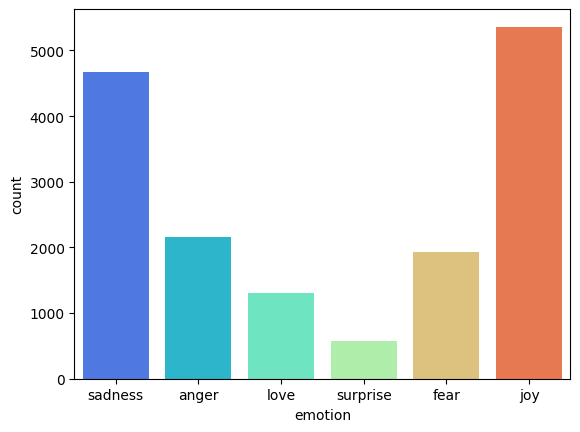

In [44]:
sns.countplot(x="emotion",data=df,palette="rainbow")

In [45]:
df.isnull().sum()

,0
text,0
emotion,0


In [46]:
emotion=df["emotion"].unique()
emo={}
for idx,value in enumerate(emotion):
  emo[value]=idx


In [47]:
emo

{'sadness': 0, 'anger': 1, 'love': 2, 'surprise': 3, 'fear': 4, 'joy': 5}

In [48]:
df["emotion"]=df["emotion"].map(emo)

In [49]:
df["emotion"].value_counts()

,count
emotion,
5,5362
0,4666
1,2159
4,1937
2,1304
3,572


# **b. Data Cleaning**

# Step1. Convert all text into lowercase

In [50]:
df["text"]=df["text"].apply(lambda x: x.lower())

# Step2. Remove any punctuation present

In [51]:
df["text"]=df["text"].apply(lambda x: x.translate(str.maketrans("","",string.punctuation)))

# Step3. Remove numbers(It may depend on the context-for emotion or spam it is recommended to remove numbers)

In [52]:
df["text"]=df["text"].apply(lambda x: x.translate(str.maketrans("","",string.digits)))

# Combine both:



```
apply(lambda x: x.translate(str.maketrans(" "," ",string.punctuation + string.digits)))
```



# Step4. Remove all the URL links or HTML tags fro proper cleaning

In [53]:
df["text"]=df["text"].astype(str).apply(lambda x: re.sub(r"http\S+|www\.\S+", "", x))

In [54]:
df["text"] = df["text"].astype(str).apply(
    lambda x: BeautifulSoup(x, "html.parser").get_text()
)

# Step5. Removing ASCII characters

In [55]:
df["text"]=df["text"].apply(lambda x: x.encode("ascii","ignore").decode())

# Step6. Removing stopwords and tokenization


*   Corpus --->(Large collections of senetences)
*   Sentence --->(collections of words)
*   Tokens --->(seperation of words)


---



In [56]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [57]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## 6.1 Use word_tokenoze instead of
``` str(x).split(" ") ```
## it will work better in terms of space




In [58]:
stop_words = set(stopwords.words('english'))

In [59]:
# df["text"].apply(lambda x: " ".join(words for words in str(x).split(" ") if words.lower() not in stop_words ))

In [60]:
df["text"]=df["text"].apply(lambda x: " ".join(words for words in word_tokenize(x) if words.lower() not in stop_words ))

# **c. Feature Extraction/Vectorization**

### c.1 GNB_pipelines and column transfers

In [61]:
b_preprocess=ColumnTransformer(transformers=[
    ("count",CountVectorizer(),"text")
]
                              )

In [62]:
gnb_bpipeline=Pipeline([
    ("preprocess",b_preprocess),
    # ("gnb",GaussianNB())
    ("mnb",MultinomialNB())
])

In [63]:
tf_preprocess=ColumnTransformer(transformers=[
    ("tf",TfidfVectorizer(),"text")
])

In [64]:
gnb_tfpipeline=Pipeline([
    ("preprocess",tf_preprocess),
    # ("gnb",GaussianNB())
    ("mnb",MultinomialNB())
])

### c.2 Split and Processing Portion

In [65]:
X_train,X_test,y_train,y_test=train_test_split(df[["text"]],df[["emotion"]],test_size=0.2,random_state=42)

In [66]:
gnb_bpipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('count', CountVectorizer(),
                                                  'text')])),
                ('mnb', MultinomialNB())])

In [67]:
y_pred_gnb=gnb_bpipeline.predict(X_test)

In [68]:
accuracy_score(y_test,y_pred_gnb)

0.7678125

In [69]:
gnb_tfpipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('tf', TfidfVectorizer(),
                                                  'text')])),
                ('mnb', MultinomialNB())])

In [70]:
y_pred_tf=gnb_tfpipeline.predict(X_test)

In [71]:
accuracy_score(y_test,y_pred_tf)

0.6609375

In [72]:
from sklearn.linear_model import LogisticRegression

In [73]:
gnb_logpipeline=Pipeline([
    ("preprocess",tf_preprocess),
    # ("gnb",GaussianNB())
    ("lr",LogisticRegression(class_weight="balanced"))
])


In [74]:
y_log_pred=gnb_logpipeline.fit(X_train,y_train).predict(X_test)

In [75]:
accuracy_score(y_test,y_log_pred)

0.885

In [76]:
joblib.dump(gnb_logpipeline,"sentiment_model.pkl")

['sentiment_model.pkl']

In [77]:
print(pd.__version__, sklearn.__version__, joblib.__version__,sns.__version__)

2.2.2 1.6.1 1.5.2 0.13.2


In [78]:
import pandas as pd, sklearn, joblib